In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
fd=pd.read_csv('train.csv')

In [3]:
fd1=pd.read_csv('test.csv')

In [4]:
fd.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [5]:
df=fd.copy()

In [6]:
df.shape

(233154, 41)

In [7]:
fd['flag']=1
fd1['flag']=0
df=fd.append(fd1,sort=False)

In [8]:
df['Date.of.Birth']=pd.to_datetime(df['Date.of.Birth'], format='%d-%m-%y')
df['Age']=2019-df['Date.of.Birth'].dt.year

In [9]:
df['manufacturer_id']= df['manufacturer_id'].astype('category')

In [10]:
df['acc_age_year']=df['AVERAGE.ACCT.AGE'].apply(lambda x: x.split(' ')[0])

df['acc_age_month']=df['AVERAGE.ACCT.AGE'].apply(lambda x: x.split(' ')[1])

In [11]:
df['acc_age']=df['acc_age_year'].str.extract('(\d+)').astype(int)*12 + df['acc_age_month'].str.extract('(\d+)').astype(int)

In [12]:
df['credit_yr']=df['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.split(' ')[0])

df['credit_month']=df['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.split(' ')[1])

In [13]:
df['credit_hist_len']=df['credit_yr'].str.extract('(\d+)').astype(int)*12 + df['credit_month'].str.extract('(\d+)').astype(int)

In [14]:
df['costbyvalue']=df.disbursed_amount/(df.asset_cost+1)

In [15]:
df['valuebycost']=df.asset_cost/(df.disbursed_amount+1)

In [16]:
df['overdue_acc__ratio']=df['PRI.OVERDUE.ACCTS']/(df['PRI.NO.OF.ACCTS']+1)
df['overdue_acc__ratio'] = df['overdue_acc__ratio'].fillna(0)

In [17]:
df['disburs_ratio']= df['PRI.DISBURSED.AMOUNT'] /( df['PRI.SANCTIONED.AMOUNT']+1)
df['disburs_ratio'] = df['disburs_ratio'].fillna(0)

In [18]:
df['loan_ratio']=df['PRI.DISBURSED.AMOUNT']/(df.disbursed_amount+1)

In [19]:
df['leftover'] = df['SEC.CURRENT.BALANCE'] /(df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']+1) 

In [20]:
df['Employment.Type'] =df['Employment.Type'].fillna(df['Employment.Type'].mode()[0])

In [21]:
X=df.drop(['State_ID','branch_id' ,'supplier_id' ,
           'UniqueID','Current_pincode_ID','Date.of.Birth','DisbursalDate','Employee_code_ID',
          'CREDIT.HISTORY.LENGTH','AVERAGE.ACCT.AGE','ltv','acc_age_year','acc_age_month',
           'credit_yr','credit_month'],1)
y=df[df['flag']==1].loan_default.reset_index(drop=True)

In [22]:
X=pd.get_dummies(X)

In [23]:
X.shape

(345546, 71)

In [24]:
test=X[X['flag']==0].reset_index(drop=True)
X=X[X['flag']==1].reset_index(drop=True)

In [25]:
test.shape,X.shape

((112392, 71), (233154, 71))

In [26]:
X['State_ID']=fd['State_ID']

In [27]:
X['Employee_code_ID']=fd['Employee_code_ID']

In [28]:
test['Employee_code_ID']=fd1['Employee_code_ID']

In [29]:
test['State_ID']=fd1['State_ID']

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

### Response rate 

In [33]:
rr=X_train.groupby('Employee_code_ID').agg({'loan_default':'sum','Employee_code_ID':'count'})

In [34]:
rr['rr']=rr['loan_default']/rr['Employee_code_ID']

In [35]:
X_train['emp_rr']=X_train['Employee_code_ID'].map(rr['rr'])
X_test['emp_rr']=X_test['Employee_code_ID'].map(rr['rr'])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
rr=X_train.groupby('State_ID').agg({'loan_default':'sum','State_ID':'count'})

In [37]:
rr['rr']=rr['loan_default']/rr['State_ID']

In [38]:
X_train['state_rr']=X_train['State_ID'].map(rr['rr'])
X_test['state_rr']=X_test['State_ID'].map(rr['rr'])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
test['emp_rr']=test['Employee_code_ID'].map(rr['rr'])

In [40]:
test['state_rr']=test['State_ID'].map(rr['rr'])

In [41]:
test=test.drop(['loan_default','Employee_code_ID','State_ID'],1)

In [43]:
X_train=X_train.drop(['loan_default','Employee_code_ID','State_ID'],1)

In [44]:
X_test=X_test.drop(['loan_default','Employee_code_ID','State_ID'],1)

In [45]:
test.shape, X_train.shape, X_test.shape

((112392, 72), (156213, 72), (76941, 72))

### random forest

In [41]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=123,
                                min_samples_leaf=5,min_samples_split=10,
                             class_weight='balanced',max_features=.8).fit(X_train,y_train)

In [42]:
accuracy_score(y_train, clf.predict(X_train)) , roc_auc_score(y_train,clf.predict(X_train))

(0.6736379174588543, 0.6815520613151378)

In [43]:
X_test['emp_rr']=X_test['emp_rr'].fillna(0)

In [47]:
accuracy_score(y_test, clf.predict(X_test)) , roc_auc_score(y_test,clf.predict(X_test))

(0.6233087690568098, 0.6052748768238752)

In [49]:
test['emp_rr']=test['emp_rr'].fillna(0)

In [56]:
a=clf.predict_proba(test)

### XGBoost

In [49]:
import xgboost as xgb

In [50]:
import gc
gc.collect()

20

In [51]:
feature=X_train.columns 

In [55]:
param = {'objective' : 'binary:logistic',
            'eta' : 0.01,
            'max_depth' : 12,
            'n_estimators':1000,
            'silent' : 1,
            'eval_metric' : "auc",
            'min_child_weight' : 5,
            'nthread' : 16,
            'subsample' : 0.8,
            'colsample_bytree' : 0.8,
            'seed' : 1}

para = list(param.items())

xgtrain = xgb.DMatrix(X_train, y_train, feature_names=feature)
xgval = xgb.DMatrix(X_test, y_test, feature_names=feature)
xgtest = xgb.DMatrix(test, feature_names=feature)
    
watchlist = [ (xgtrain,'train'), (xgval, 'valid') ]
model = xgb.train(para, xgtrain, num_boost_round=3000, evals= watchlist, early_stopping_rounds=20, verbose_eval = 10)   
    
pred_Val_y = model.predict(xgtest)

[0]	train-auc:0.712161	valid-auc:0.621456
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.764134	valid-auc:0.650685
[20]	train-auc:0.76989	valid-auc:0.652928
[30]	train-auc:0.773324	valid-auc:0.653047
[40]	train-auc:0.776886	valid-auc:0.653058
[50]	train-auc:0.77836	valid-auc:0.652453
[60]	train-auc:0.781633	valid-auc:0.653778
[70]	train-auc:0.783757	valid-auc:0.654242
[80]	train-auc:0.785858	valid-auc:0.654291
Stopping. Best iteration:
[66]	train-auc:0.783197	valid-auc:0.654504



In [56]:
roc_auc_score(y_test,model.predict(xgval)),  roc_auc_score(y_train,model.predict(xgtrain))

(0.6540001969840771, 0.7868961177966333)

In [77]:
(0.6536656372389669, 0.8119114154680921)

(0.6536656372389669, 0.8119114154680921)

In [58]:
sub=pd.DataFrame(pred_Val_y,columns=['loan_default']) 

In [59]:
sub['UniqueID'] = fd1['UniqueID']

In [61]:
sub.head()

,loan_default,UniqueID
0,0.227823,655269
1,0.228558,723482
2,0.225876,758529
3,0.228564,763449
4,0.227294,708663


In [60]:
sub.to_csv('output.csv',index=False)

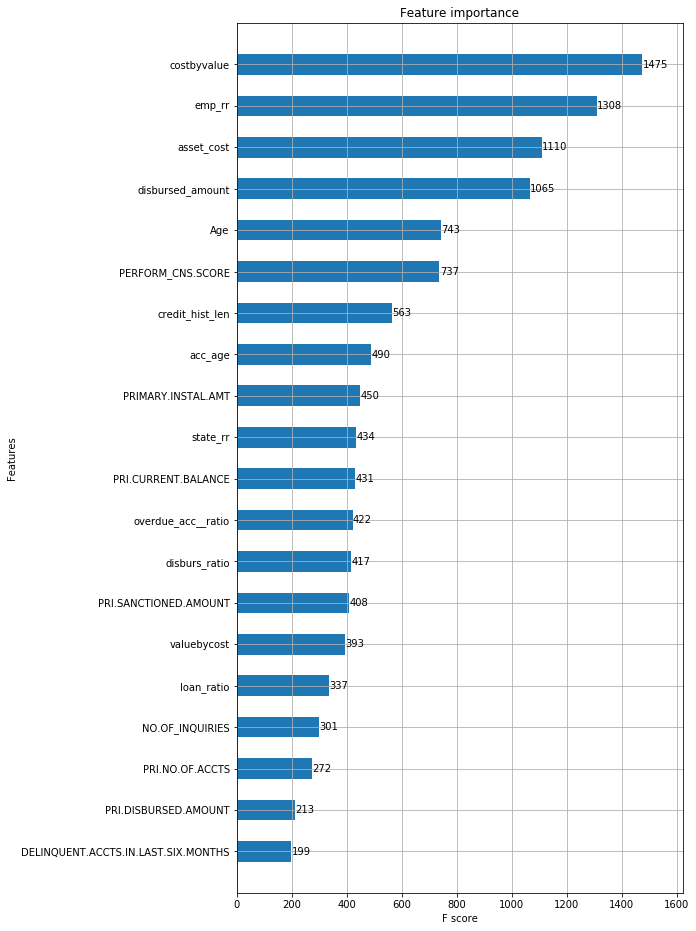

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax)

### lgb

In [62]:
import lightgbm as lgb

In [63]:
import gc
gc.collect()

2838

In [64]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.01,
    'verbose': 10
}

para = list(param.items())

lgtrain = lgb.Dataset(X_train, y_train)
lgval = lgb.Dataset(X_test, y_test)
ltest = lgb.Dataset(test)
    
#model = lgb.train(para, train_set =lgtrain, valid_sets = lgval, num_boost_round=3000,  early_stopping_rounds=20) 

model = lgb.train(parameters,
                       lgtrain,
                       valid_sets=lgval,
                       num_boost_round=3000,
                       early_stopping_rounds=20)
    
pred_Val_y = model.predict(test)

[1]	valid_0's auc: 0.628306
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.62873
[3]	valid_0's auc: 0.640667
[4]	valid_0's auc: 0.639057
[5]	valid_0's auc: 0.638455
[6]	valid_0's auc: 0.637791
[7]	valid_0's auc: 0.637391
[8]	valid_0's auc: 0.641211
[9]	valid_0's auc: 0.640645
[10]	valid_0's auc: 0.640155
[11]	valid_0's auc: 0.639774
[12]	valid_0's auc: 0.639646
[13]	valid_0's auc: 0.639295
[14]	valid_0's auc: 0.639164
[15]	valid_0's auc: 0.638901
[16]	valid_0's auc: 0.640582
[17]	valid_0's auc: 0.640501
[18]	valid_0's auc: 0.64039
[19]	valid_0's auc: 0.640066
[20]	valid_0's auc: 0.639915
[21]	valid_0's auc: 0.639927
[22]	valid_0's auc: 0.639835
[23]	valid_0's auc: 0.639859
[24]	valid_0's auc: 0.639813
[25]	valid_0's auc: 0.640998
[26]	valid_0's auc: 0.641035
[27]	valid_0's auc: 0.640966
[28]	valid_0's auc: 0.640868
Early stopping, best iteration is:
[8]	valid_0's auc: 0.641211


In [65]:
roc_auc_score(y_test,model.predict(X_test)),  roc_auc_score(y_train,model.predict(X_train))

(0.6412110861900674, 0.685911765061501)

In [86]:
(0.6549405427992118, 0.7254986565008952)

(0.6549405427992118, 0.7254986565008952)

In [87]:
sub['lgb'] = pred_Val_y

In [91]:
sub.to_csv('output.csv',index=False)

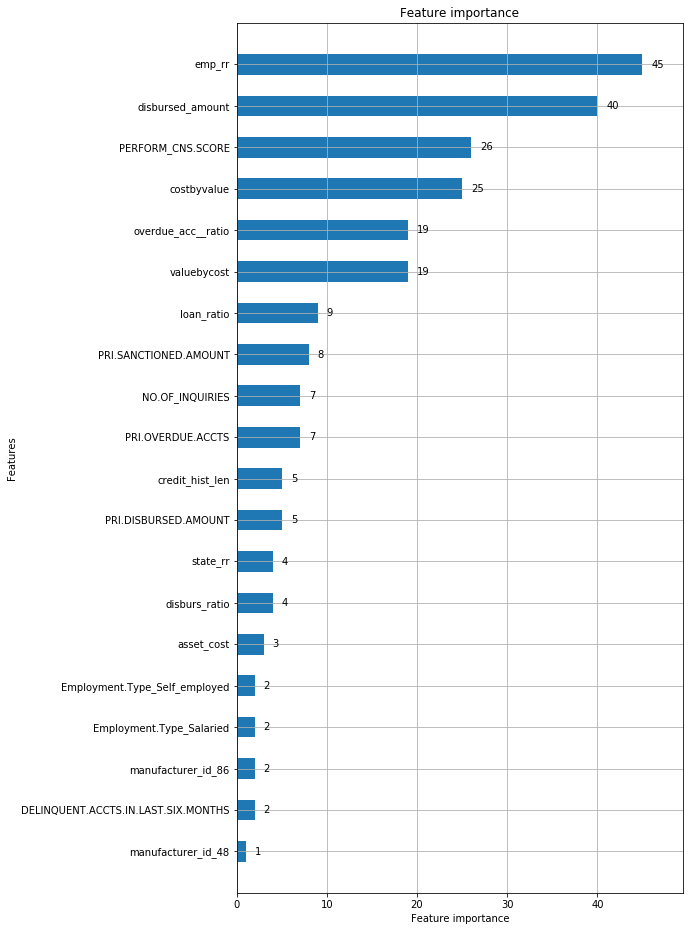

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
lgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax)

### Catboost